# GBM
- 부스팅 알고리즘은 여러 개의 약한 학습기를 순차적으로 학습-예측하면서 잘못 예측한 데이터에 가중치를 부여하여 오류를 개선해 나가면서 학습하는 방식
- AdaBoost와 GradientBoost

In [1]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score
import pandas as pd
import time
import warnings
warnings.filterwarnings('ignore')

def get_human_dataset():
    
    # 각 데이터 파일들은 공백으로 분리되어 있음. 공백 문자를 sep으로 할당
    feature_name_df = pd.read_csv('./data/UCI_HAR_Dataset/features.txt', sep='\s+',
                                  header=None, names=['column_index', 'column_name'])
    # DataFrame에 피처명을 칼럼으로 부여하기 위해 리스트 객체로 다시 변환
    feature_name = feature_name_df.iloc[:,1].values.tolist()

    # 학습 feature 데이터 세트와 test 데이터를 DataFrame으로 로딩
    x_train = pd.read_csv('./data/UCI_HAR_Dataset/train/X_train.txt', sep='\s+', names=feature_name)
    x_test = pd.read_csv('./data/UCI_HAR_Dataset/test/X_test.txt', sep='\s+', names=feature_name)
    
    # 학습 레이블과 테스트 레이블 데이터를 DataFrame으로 로딩
    y_train = pd.read_csv('./data/UCI_HAR_Dataset/train/y_train.txt', sep='\s+', header=None, names=['action'])
    y_test = pd.read_csv('./data/UCI_HAR_Dataset/test/y_test.txt', sep='\s+', header=None, names=['action'])
    
    # 로드된 학습/테스트용 DataFrame을 모두 반환
    return x_train, x_test, y_train, y_test

x_train, x_test, y_train, y_test = get_human_dataset()

# GBM 수행 시간 측정을 위함. 시작 시간 설정.
start_time = time.time()

In [9]:
gb_clf = GradientBoostingClassifier()
gb_clf.fit(x_train, y_train)
gb_pred = gb_clf.predict(x_test)
gb_accuracy = accuracy_score(y_test, gb_pred)

print('GBM 정확도: {0:.4f}'.format(gb_accuracy))
print('GBM 수행 시간: {0:.1f} 초'.format(time.time()-start_time))

GBM 정확도: 0.9389
GBM 수행 시간: 1914.7 초


## 하이퍼 파라미터에 따른 영향 확인
- n_estimators, max_depth, max_features

```
from sklearn.model_selection import GridSearchCV

params = {
    'n_estimators' : [100, 500],
    'learning_rate' : [0.05, 0.1]
}
grid_cv = GridSearchCV(gb_clf, param_grid=params, cv=2, verbose=1)
grid_cv.fit(x_train, y_train)
print('최적 하이퍼 파라미터:\n', grid_cv.best_params_)
print('최고 예측 정확도: {0:.4f}'.format(grid_cv.best_score_))
```

```
gb_pred = grid_cv.best_estimator_.predict(x_test)
gb_accuracy = accuracy_score(y_test, gb_pred)
print('GBM 정확도: {0:.4f}'.format(gb_accuracy))
```

# XGBoost

In [3]:
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier

cancer = load_breast_cancer()
x_train, x_test, y_train, y_test = train_test_split(cancer.data, cancer.target, test_size=0.2, random_state=156)

xgb_wrapper = XGBClassifier(n_estimators=400, learning_rate=0.1, max_depth=3)
xgb_wrapper.fit(x_train, y_train)
w_preds = xgb_wrapper.predict(x_test)

In [6]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix
import numpy as np

def get_clf_eval(y_test, pred):
    confusion = confusion_matrix(y_test, pred)
    accuracy = accuracy_score(y_test, pred)
    precision = precision_score(y_test, pred)
    recall = recall_score(y_test, pred)
    print('오차 행렬')
    print(confusion)
    print('정확도: {0:.4f}, 정밀도: {1:.4f}, 재현율: {2:.4f}'.format(accuracy, precision, recall))

In [8]:
get_clf_eval(y_test, w_preds)

오차 행렬
[[35  2]
 [ 1 76]]
정확도: 0.9737, 정밀도: 0.9744, 재현율: 0.9870


### - XGBoost 조기 중단 파라미터

In [10]:
xgb_wrapper.fit(x_train, y_train, early_stopping_rounds=100, eval_metric='logloss',
               eval_set=[(x_test, y_test)], verbose=True)
# 여기서 eval_set을 test data를 사용하였으나 원칙적으로는 test data 사용하면 안됨
ws100_preds = xgb_wrapper.predict(x_test)

[0]	validation_0-logloss:0.61352
Will train until validation_0-logloss hasn't improved in 100 rounds.
[1]	validation_0-logloss:0.547842
[2]	validation_0-logloss:0.494247
[3]	validation_0-logloss:0.447986
[4]	validation_0-logloss:0.409109
[5]	validation_0-logloss:0.374977
[6]	validation_0-logloss:0.345714
[7]	validation_0-logloss:0.320529
[8]	validation_0-logloss:0.29721
[9]	validation_0-logloss:0.277991
[10]	validation_0-logloss:0.260302
[11]	validation_0-logloss:0.246037
[12]	validation_0-logloss:0.231556
[13]	validation_0-logloss:0.22005
[14]	validation_0-logloss:0.208572
[15]	validation_0-logloss:0.199993
[16]	validation_0-logloss:0.190118
[17]	validation_0-logloss:0.181818
[18]	validation_0-logloss:0.174729
[19]	validation_0-logloss:0.167657
[20]	validation_0-logloss:0.158202
[21]	validation_0-logloss:0.154725
[22]	validation_0-logloss:0.148947
[23]	validation_0-logloss:0.143308
[24]	validation_0-logloss:0.136344
[25]	validation_0-logloss:0.132778
[26]	validation_0-logloss:0.127912

[230]	validation_0-logloss:0.086002
[231]	validation_0-logloss:0.085922
[232]	validation_0-logloss:0.086102
[233]	validation_0-logloss:0.086115
[234]	validation_0-logloss:0.086169
[235]	validation_0-logloss:0.086263
[236]	validation_0-logloss:0.086292
[237]	validation_0-logloss:0.086217
[238]	validation_0-logloss:0.086395
[239]	validation_0-logloss:0.086342
[240]	validation_0-logloss:0.08618
[241]	validation_0-logloss:0.086195
[242]	validation_0-logloss:0.086248
[243]	validation_0-logloss:0.086263
[244]	validation_0-logloss:0.086293
[245]	validation_0-logloss:0.086222
[246]	validation_0-logloss:0.086398
[247]	validation_0-logloss:0.086347
[248]	validation_0-logloss:0.086276
[249]	validation_0-logloss:0.086448
[250]	validation_0-logloss:0.086294
[251]	validation_0-logloss:0.086312
[252]	validation_0-logloss:0.086364
[253]	validation_0-logloss:0.086394
[254]	validation_0-logloss:0.08649
[255]	validation_0-logloss:0.086441
[256]	validation_0-logloss:0.08629
[257]	validation_0-logloss:0.08

In [11]:
get_clf_eval(y_test, ws100_preds)

오차 행렬
[[34  3]
 [ 1 76]]
정확도: 0.9649, 정밀도: 0.9620, 재현율: 0.9870


## 피쳐의 중요도 시각화

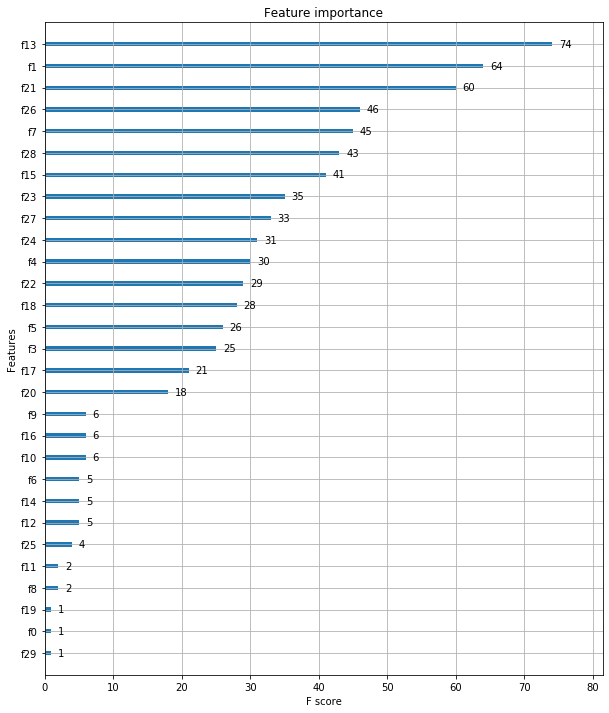

In [13]:
from xgboost import plot_importance
import matplotlib.pyplot as plt
%matplotlib inline

fig, ax = plt.subplots(figsize=(10,12))
# 사이킷런 Wrapper 클래스를 입력해도 무방
plot_importance(xgb_wrapper, ax=ax)

# LightGBM
- XGB와 성능은 비슷하고 기능한 다양성 제공, Light함
- 단, 적은 데이터 세트에 적용할 경우 과적합이 발생 (약 10,000건 이하)
- 기존 GBM 트리 분할 방식은 트리의 깊이를 효과적으로 줄이기 위해 "균형트리분할"을 사용
- 그러나 균형을 맞추기 위한 시간이 필요
- LightGBM 트리 분할 방식은 균형대신 최대 손실값을 가지는 리프 노드를 지속적으로 분할하여 트리의 깊이가 깊어지고 비대칭 구조인 "리프 중심 트리 분할" 방식을 사용

In [2]:
from lightgbm import LGBMClassifier

import pandas as pd
import numpy as np
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split

dataset = load_breast_cancer()
ftr = dataset.data
target = dataset.target

C:\Anaconda3\envs\aiinovation\lib\importlib\_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)


In [4]:
# 80% Train, 20% Test 추출
x_train, x_test, y_train, y_test = train_test_split(ftr, target, test_size=0.2, random_state=156)

lgbm_wrapper = LGBMClassifier(n_estimators=400)

# LightGBM도 XGBoost와 동일하게 조기 중단 수행 가능.
lgbm_wrapper.fit(x_train, y_train, early_stopping_rounds=100, eval_metric='logloss',
                eval_set=[(x_test, y_test)], verbose=True)
preds = lgbm_wrapper.predict(x_test)

[1]	valid_0's binary_logloss: 0.565079
Training until validation scores don't improve for 100 rounds
[2]	valid_0's binary_logloss: 0.507451
[3]	valid_0's binary_logloss: 0.458489
[4]	valid_0's binary_logloss: 0.417481
[5]	valid_0's binary_logloss: 0.385507
[6]	valid_0's binary_logloss: 0.355846
[7]	valid_0's binary_logloss: 0.330897
[8]	valid_0's binary_logloss: 0.306923
[9]	valid_0's binary_logloss: 0.28776
[10]	valid_0's binary_logloss: 0.26917
[11]	valid_0's binary_logloss: 0.250954
[12]	valid_0's binary_logloss: 0.23847
[13]	valid_0's binary_logloss: 0.225865
[14]	valid_0's binary_logloss: 0.215076
[15]	valid_0's binary_logloss: 0.205996
[16]	valid_0's binary_logloss: 0.196091
[17]	valid_0's binary_logloss: 0.186395
[18]	valid_0's binary_logloss: 0.17942
[19]	valid_0's binary_logloss: 0.174727
[20]	valid_0's binary_logloss: 0.168563
[21]	valid_0's binary_logloss: 0.165432
[22]	valid_0's binary_logloss: 0.160356
[23]	valid_0's binary_logloss: 0.155508
[24]	valid_0's binary_logloss: 

In [7]:
get_clf_eval(y_test, preds)

오차 행렬
[[33  4]
 [ 2 75]]
정확도: 0.9474, 정밀도: 0.9494, 재현율: 0.9740


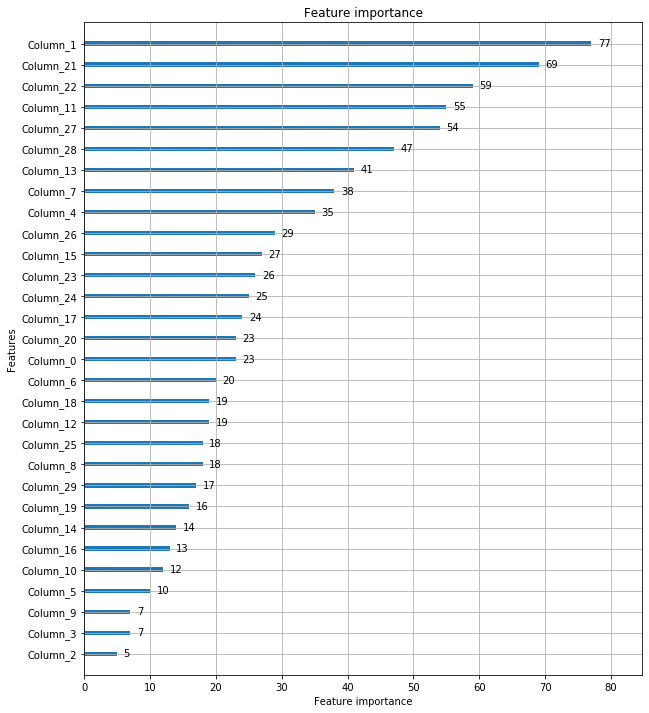

In [8]:
from lightgbm import plot_importance
import matplotlib.pyplot as plt
%matplotlib inline

fig, ax = plt.subplots(figsize=(10,12))
# 사이킷런 Wrapper 클래스를 입력해도 무방
plot_importance(lgbm_wrapper, ax=ax)